# Day 3: Mean-Variance Optimization in Practice
## Week 5: Portfolio Optimization

---

**Learning Objectives:**
- Understand MVO limitations (estimation error)
- Implement robust covariance estimation
- Add constraints (sector, turnover, factor exposure)
- Black-Litterman model basics

In [1]:
# Day 3 Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.covariance import LedoitWolf, EmpiricalCovariance
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

TRADING_DAYS = 252
RF_RATE = 0.05

# Load data
df = pd.read_csv('../datasets/raw_data/combined_adjusted_close.csv', 
                 index_col='Date', parse_dates=True)

assets = ['AAPL', 'MSFT', 'JPM', 'XOM', 'GLD', 'TLT', 'SPY']
prices = df[assets].dropna()
returns = prices.pct_change().dropna()

print("=" * 60)
print("MVO IN PRACTICE - DAY 3")
print("=" * 60)

MVO IN PRACTICE - DAY 3


## 1. The Problem with MVO: Estimation Error

In [2]:
# Demonstrate estimation instability
print("=" * 60)
print("ESTIMATION ERROR PROBLEM")
print("=" * 60)

def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def max_sharpe_portfolio(mean_returns, cov_matrix, rf_rate=RF_RATE):
    """Find maximum Sharpe ratio portfolio."""
    n = len(mean_returns)
    
    def neg_sharpe(w):
        ret = portfolio_return(w, mean_returns)
        vol = portfolio_volatility(w, cov_matrix)
        return -(ret - rf_rate) / vol
    
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    
    result = minimize(neg_sharpe, np.array([1/n]*n), method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

# Split data into different windows
windows = [
    ('Window 1', returns.iloc[:300]),
    ('Window 2', returns.iloc[300:600]),
    ('Window 3', returns.iloc[600:900]),
    ('Window 4', returns.iloc[900:1200])
]

results = []
for name, window_returns in windows:
    mean_ret = window_returns.mean() * TRADING_DAYS
    cov_mat = window_returns.cov() * TRADING_DAYS
    
    try:
        weights = max_sharpe_portfolio(mean_ret, cov_mat)
        results.append({
            'Window': name,
            **{asset: weight for asset, weight in zip(assets, weights)}
        })
    except:
        pass

results_df = pd.DataFrame(results)
print("\n📊 Optimal Weights by Window:")
print(results_df.round(3).to_string(index=False))

print("\n⚠️ Problem: Optimal weights vary dramatically across windows!")
print("   This is because small changes in estimated means cause large weight changes.")

ESTIMATION ERROR PROBLEM

📊 Optimal Weights by Window:
  Window  AAPL  MSFT   JPM   XOM   GLD   TLT  SPY
Window 1 0.226 0.078 0.000 0.000 0.105 0.591  0.0
Window 2 0.412 0.000 0.182 0.117 0.290 0.000  0.0
Window 3 0.283 0.000 0.000 0.717 0.000 0.000  0.0
Window 4 0.000 0.163 0.680 0.157 0.000 0.000  0.0

⚠️ Problem: Optimal weights vary dramatically across windows!
   This is because small changes in estimated means cause large weight changes.


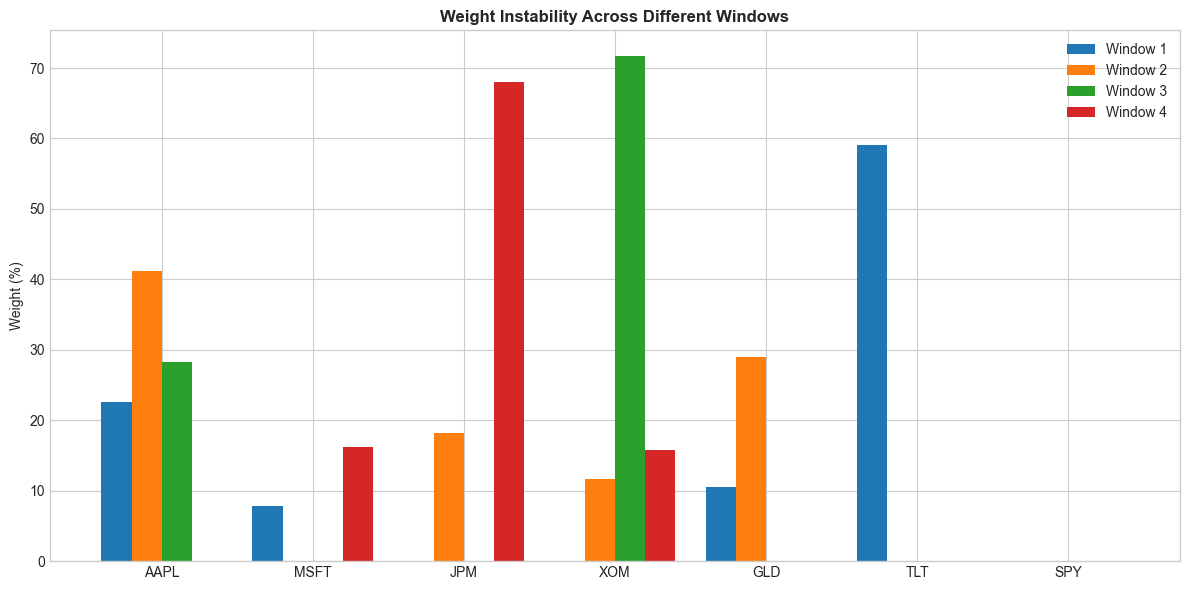

In [3]:
# Visualize weight instability
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(assets))
width = 0.2

for i, (idx, row) in enumerate(results_df.iterrows()):
    weights = row[assets].values.astype(float)
    ax.bar(x + i*width, weights * 100, width, label=row['Window'])

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(assets)
ax.set_ylabel('Weight (%)')
ax.set_title('Weight Instability Across Different Windows', fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

## 2. Robust Covariance Estimation

ROBUST COVARIANCE ESTIMATION

Ledoit-Wolf Shrinkage Coefficient: 0.0187

(Higher = more regularization toward identity matrix)

Condition Number (lower is more stable):
  Sample: 61.90
  Shrunk: 47.43


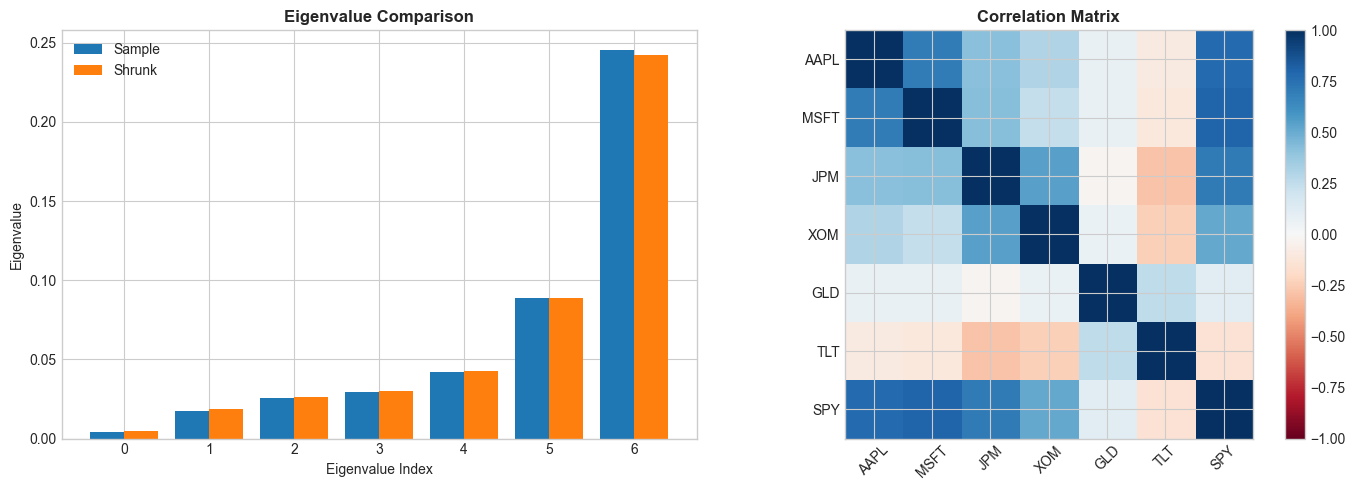

In [4]:
# Ledoit-Wolf shrinkage
print("=" * 60)
print("ROBUST COVARIANCE ESTIMATION")
print("=" * 60)

# Sample covariance
sample_cov = returns.cov() * TRADING_DAYS

# Ledoit-Wolf shrinkage
lw = LedoitWolf().fit(returns)
shrunk_cov = pd.DataFrame(lw.covariance_ * TRADING_DAYS, 
                          index=assets, columns=assets)

print(f"\nLedoit-Wolf Shrinkage Coefficient: {lw.shrinkage_:.4f}")
print("\n(Higher = more regularization toward identity matrix)")

# Compare eigenvalues
sample_eig = np.linalg.eigvalsh(sample_cov)
shrunk_eig = np.linalg.eigvalsh(shrunk_cov)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Eigenvalue comparison
axes[0].bar(np.arange(len(sample_eig)) - 0.2, sample_eig, 0.4, label='Sample')
axes[0].bar(np.arange(len(shrunk_eig)) + 0.2, shrunk_eig, 0.4, label='Shrunk')
axes[0].set_xlabel('Eigenvalue Index')
axes[0].set_ylabel('Eigenvalue')
axes[0].set_title('Eigenvalue Comparison', fontweight='bold')
axes[0].legend()

# Condition number
print(f"\nCondition Number (lower is more stable):")
print(f"  Sample: {sample_eig.max() / sample_eig.min():.2f}")
print(f"  Shrunk: {shrunk_eig.max() / shrunk_eig.min():.2f}")

# Correlation comparison
sample_corr = returns.corr()
im = axes[1].imshow(sample_corr, cmap='RdBu', vmin=-1, vmax=1)
axes[1].set_xticks(range(len(assets)))
axes[1].set_yticks(range(len(assets)))
axes[1].set_xticklabels(assets, rotation=45)
axes[1].set_yticklabels(assets)
axes[1].set_title('Correlation Matrix', fontweight='bold')
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

## 3. Constrained Optimization

In [5]:
# Constrained optimization
print("=" * 60)
print("CONSTRAINED OPTIMIZATION")
print("=" * 60)

mean_returns = returns.mean() * TRADING_DAYS
cov_matrix = shrunk_cov  # Use shrunk covariance

# Define sectors (simplified)
sectors = {
    'Tech': ['AAPL', 'MSFT'],
    'Finance': ['JPM'],
    'Energy': ['XOM'],
    'Commodities': ['GLD'],
    'Bonds': ['TLT'],
    'Index': ['SPY']
}

asset_to_idx = {asset: i for i, asset in enumerate(assets)}

def constrained_max_sharpe(mean_returns, cov_matrix, 
                           max_weight=0.4, 
                           max_sector_weight=0.5,
                           rf_rate=RF_RATE):
    """Max Sharpe with constraints."""
    n = len(mean_returns)
    
    def neg_sharpe(w):
        ret = portfolio_return(w, mean_returns)
        vol = portfolio_volatility(w, cov_matrix)
        return -(ret - rf_rate) / vol
    
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1
    ]
    
    # Add sector constraints
    for sector, sector_assets in sectors.items():
        indices = [asset_to_idx[a] for a in sector_assets if a in asset_to_idx]
        if indices:
            constraints.append({
                'type': 'ineq',
                'fun': lambda x, idx=indices: max_sector_weight - sum(x[i] for i in idx)
            })
    
    # Individual weight bounds
    bounds = tuple((0, max_weight) for _ in range(n))
    
    result = minimize(neg_sharpe, np.array([1/n]*n), method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

# Unconstrained
unconstrained_weights = max_sharpe_portfolio(mean_returns, cov_matrix)

# Constrained
constrained_weights = constrained_max_sharpe(mean_returns, cov_matrix,
                                             max_weight=0.3, max_sector_weight=0.4)

# Compare
comparison = pd.DataFrame({
    'Asset': assets,
    'Unconstrained': unconstrained_weights,
    'Constrained': constrained_weights
})

print("\n📊 Weight Comparison:")
print(comparison.round(4).to_string(index=False))

# Performance comparison
print("\n📊 Performance Comparison:")
for name, w in [('Unconstrained', unconstrained_weights), ('Constrained', constrained_weights)]:
    ret = portfolio_return(w, mean_returns)
    vol = portfolio_volatility(w, cov_matrix)
    sharpe = (ret - RF_RATE) / vol
    print(f"  {name}: Return={ret:.2%}, Vol={vol:.2%}, Sharpe={sharpe:.3f}")

CONSTRAINED OPTIMIZATION

📊 Weight Comparison:
Asset  Unconstrained  Constrained
 AAPL         0.2042       0.2735
 MSFT         0.0711       0.1265
  JPM         0.1320       0.1907
  XOM         0.0000       0.0608
  GLD         0.5926       0.3000
  TLT         0.0000       0.0485
  SPY         0.0000       0.0000

📊 Performance Comparison:
  Unconstrained: Return=22.81%, Vol=14.24%, Sharpe=1.251
  Constrained: Return=23.43%, Vol=16.46%, Sharpe=1.119


## 4. Turnover Constraints

In [6]:
# Turnover-constrained optimization
print("=" * 60)
print("TURNOVER CONSTRAINTS")
print("=" * 60)

def turnover_constrained_portfolio(mean_returns, cov_matrix, current_weights,
                                   max_turnover=0.2, rf_rate=RF_RATE):
    """Optimize with turnover constraint."""
    n = len(mean_returns)
    
    def neg_sharpe(w):
        ret = portfolio_return(w, mean_returns)
        vol = portfolio_volatility(w, cov_matrix)
        return -(ret - rf_rate) / vol
    
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'ineq', 'fun': lambda x: max_turnover - np.sum(np.abs(x - current_weights))}
    ]
    
    bounds = tuple((0, 1) for _ in range(n))
    
    result = minimize(neg_sharpe, current_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

# Start with equal weights
current_weights = np.array([1/len(assets)] * len(assets))

# Different turnover limits
turnover_limits = [0.1, 0.2, 0.5, 1.0]

turnover_results = []
for max_to in turnover_limits:
    new_weights = turnover_constrained_portfolio(mean_returns, cov_matrix, 
                                                  current_weights, max_to)
    actual_turnover = np.sum(np.abs(new_weights - current_weights))
    ret = portfolio_return(new_weights, mean_returns)
    vol = portfolio_volatility(new_weights, cov_matrix)
    sharpe = (ret - RF_RATE) / vol
    
    turnover_results.append({
        'Max Turnover': max_to,
        'Actual Turnover': actual_turnover,
        'Return': ret,
        'Volatility': vol,
        'Sharpe': sharpe
    })

to_df = pd.DataFrame(turnover_results)
print("\n📊 Turnover Impact:")
print(to_df.round(4).to_string(index=False))

print("\n💡 Insight: Tighter turnover constraints reduce Sharpe but also trading costs")

TURNOVER CONSTRAINTS

📊 Turnover Impact:
 Max Turnover  Actual Turnover  Return  Volatility  Sharpe
          0.1              0.1  0.1973      0.1505  0.9781
          0.2              0.2  0.2017      0.1480  1.0250
          0.5              0.5  0.2093      0.1383  1.1522
          1.0              1.0  0.2279      0.1422  1.2508

💡 Insight: Tighter turnover constraints reduce Sharpe but also trading costs


## 5. Transaction Cost Awareness

In [7]:
# Transaction cost adjusted optimization
print("=" * 60)
print("TRANSACTION COST ADJUSTED")
print("=" * 60)

def net_sharpe_with_costs(mean_returns, cov_matrix, current_weights,
                          transaction_cost=0.001, rf_rate=RF_RATE):
    """Optimize net Sharpe after transaction costs."""
    n = len(mean_returns)
    
    def neg_net_sharpe(w):
        ret = portfolio_return(w, mean_returns)
        vol = portfolio_volatility(w, cov_matrix)
        
        # Subtract transaction costs from expected return
        turnover = np.sum(np.abs(w - current_weights))
        net_ret = ret - transaction_cost * turnover
        
        return -(net_ret - rf_rate) / vol
    
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for _ in range(n))
    
    result = minimize(neg_net_sharpe, current_weights, method='SLSQP',
                     bounds=bounds, constraints=constraints)
    return result.x

# Compare different transaction costs
tc_levels = [0, 0.001, 0.005, 0.01]

tc_results = []
for tc in tc_levels:
    new_weights = net_sharpe_with_costs(mean_returns, cov_matrix, 
                                        current_weights, tc)
    actual_turnover = np.sum(np.abs(new_weights - current_weights))
    
    ret = portfolio_return(new_weights, mean_returns)
    net_ret = ret - tc * actual_turnover
    vol = portfolio_volatility(new_weights, cov_matrix)
    
    tc_results.append({
        'TC (bps)': tc * 10000,
        'Turnover': actual_turnover,
        'Gross Return': ret,
        'Net Return': net_ret,
        'Net Sharpe': (net_ret - RF_RATE) / vol
    })

tc_df = pd.DataFrame(tc_results)
print("\n📊 Transaction Cost Impact:")
print(tc_df.round(4).to_string(index=False))

TRANSACTION COST ADJUSTED

📊 Transaction Cost Impact:
 TC (bps)  Turnover  Gross Return  Net Return  Net Sharpe
      0.0    1.0223        0.2281      0.2281      1.2509
     10.0    1.0094        0.2281      0.2271      1.2438
     50.0    0.9612        0.2281      0.2233      1.2161
    100.0    0.8910        0.2276      0.2187      1.1836


## 📝 Key Takeaways - Day 3

### MVO Problems:
1. **Estimation Error**: Small input changes → large weight changes
2. **Error Maximization**: MVO concentrates in assets with highest estimation error
3. **Extreme Positions**: Without constraints, produces impractical portfolios

### Solutions:
| Problem | Solution |
|---------|----------|
| Covariance instability | Shrinkage estimation |
| Extreme weights | Weight bounds |
| Concentration | Sector limits |
| High turnover | Turnover constraints |
| Transaction costs | Cost-adjusted optimization |

### Interview Questions:
- "What are the problems with mean-variance optimization?"
- "How does Ledoit-Wolf shrinkage help?"
- "What constraints would you add to a portfolio optimizer?"